# King County House Sales Analysis

## Overview

A large real estate firm in the Seattle area is seeking to maximize prices for home sellers.  My task is to use data from previous home sales to predict future prices.  

## Business Problem
The real estate firm operates throughout King County, which includes the metropolis of Seattle, as well as suburban and rural areas.  Home prices vary greatly between these diverse landscapes, as well as between neighborhoods in Seattle.  The firm needs to accurately price a home based on data such as its size, location, and number of bedrooms, in order to get the best sale price for its clients.  It needs a model that can generate a good estimate of value for any home in the county.

## Data Understanding

To build a model to predict  prices, I used data from the King County House Sales dataset, which can be found here:

(https://www.kaggle.com/harlfoxem/housesalesprediction)

This dataset contains information on over 21,000 houses sold in King County between May, 2014 and May, 2015.  Although the median sale price is \\$450,000, the dataset also includes multi-million dollar homes.  At the top of the market are about 1,000 properties which sold between \\$1.2 million and \\$7.7 million, so the price data are right-skewed with a few very high outliers.

In addition to sale price, the dataset includes details about the homes, including square footage, lot square footage, number of bedrooms, zip code, and the dates when the houses were built, renovated, and sold.  Although the data seem mostly accurate, some values are missing, and many columns have outliers on the high side.

Definitions of all column names are below:

### Column Names and Descriptions for King County Data Set

* **id** - unique identifier for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  number of bedrooms
* **bathrooms** -  number of bathrooms
* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


## Data Cleaning and Preprocessing

### Right-Skewed Columns and Outliers

While exploring the data, I found several columns that are right skewed, including:
* price
* bedrooms
* bathrooms
* sqft_living
* sqft_lot
* sqft_above
* sqft_living15
* sqft_lot15

In this section, I investigated the right-skewed columns.  I found that although some have high outliers, the data do not appear inaccurate -- except for one home reported to have 33 bedrooms.  I removed the highest outliers in price from the data to improve the model's accuracy for the remaining homes.  Later, I will use log transformation on some columns to reduce the effect of the skewness.

In [1]:
# import packages

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [2]:
# import data

data = pd.read_csv('data/kc_house_data.csv')

In [3]:
# split data into test and training sets

# choose relevant columns:

X=data.drop(columns=['price'])

y=data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

15117 6480 15117 6480


In [4]:
# concatenate X_train and y_train back together for initial exploration

train_data = pd.concat([X_train, y_train], axis=1)
train_data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
753,8682300890,8/28/2014,2,2.50000,2380,6600,1.00000,nan,0.00000,3,8,2380,0.0,2010,nan,98053,47.71700,-122.02000,1870,6600,699800.00000
1418,8073000550,4/15/2015,4,3.75000,3190,17186,2.00000,1.00000,4.00000,3,10,3190,0.0,1999,0.00000,98178,47.51150,-122.24600,2290,13496,1700000.00000
8178,7212680850,9/3/2014,3,2.50000,1730,6930,2.00000,0.00000,0.00000,3,8,1730,0.0,1994,0.00000,98003,47.26210,-122.30800,1780,6930,258000.00000
2254,8880600070,11/12/2014,4,2.00000,1870,8750,1.00000,0.00000,2.00000,3,7,1870,0.0,1977,0.00000,98022,47.19850,-122.00100,1770,8207,245000.00000
4063,7226500100,2/19/2015,8,3.00000,2850,12714,1.00000,nan,0.00000,3,7,2850,0.0,1959,0.00000,98055,47.48590,-122.20500,1480,4942,373000.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,7853230570,9/15/2014,3,2.50000,2230,5800,2.00000,0.00000,0.00000,3,7,2230,0.0,2004,0.00000,98065,47.53080,-121.84700,2230,6088,440000.00000
21575,4140940150,10/2/2014,4,2.75000,2770,3852,2.00000,0.00000,0.00000,3,8,2770,0.0,2014,nan,98178,47.50010,-122.23200,1810,5641,572000.00000
5390,8658300480,7/21/2014,4,1.50000,1530,9000,1.00000,0.00000,0.00000,4,6,1530,0.0,1976,0.00000,98014,47.64920,-121.90800,1520,8500,299800.00000
860,1723049033,6/20/2014,1,0.75000,380,15000,1.00000,0.00000,0.00000,3,5,380,0.0,1963,0.00000,98168,47.48100,-122.32300,1170,15000,245000.00000


In [5]:
# explore training data

train_data.head(500)
train_data.info()
train_data.describe()

# questions and observations:
# high outliers in price, bedrooms, bathrooms, sqft_living, sqft_lot
# null values in waterfront, view, yr_renovated
# waterfront has lots of 0s in addition to null values
# need to turn date (sale date) into a date
# need to turn sqft_basement into a float (but it has some non-number values, like ?)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 753 to 15795
Data columns (total 21 columns):
id               15117 non-null int64
date             15117 non-null object
bedrooms         15117 non-null int64
bathrooms        15117 non-null float64
sqft_living      15117 non-null int64
sqft_lot         15117 non-null int64
floors           15117 non-null float64
waterfront       13467 non-null float64
view             15073 non-null float64
condition        15117 non-null int64
grade            15117 non-null int64
sqft_above       15117 non-null int64
sqft_basement    15117 non-null object
yr_built         15117 non-null int64
yr_renovated     12418 non-null float64
zipcode          15117 non-null int64
lat              15117 non-null float64
long             15117 non-null float64
sqft_living15    15117 non-null int64
sqft_lot15       15117 non-null int64
price            15117 non-null float64
dtypes: float64(8), int64(11), object(2)
memory usage: 2.5+ MB


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,15117.00000,15117.00000,15117.00000,15117.00000,15117.00000,15117.00000,13467.00000,15073.00000,15117.00000,15117.00000,15117.00000,15117.00000,12418.00000,15117.00000,15117.00000,15117.00000,15117.00000,15117.00000,15117.00000
mean,4595180775.49031,3.37600,2.11995,2087.04062,15169.37832,1.49636,0.00765,0.23287,3.40921,7.66071,1793.52160,1971.09082,82.78129,98078.17907,47.56089,-122.21384,1990.05861,12854.45604,542036.63544
std,2889110228.57206,0.90917,0.77023,922.64361,41063.71788,0.54095,0.08712,0.76726,0.65082,1.17205,830.31968,29.33964,398.00404,53.58806,0.13822,0.14149,686.93544,27118.16989,368729.35025
min,1000102.00000,1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000,78000.00000
25%,2115720130.00000,3.00000,1.75000,1430.00000,5070.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1200.00000,1952.00000,0.00000,98033.00000,47.47180,-122.32900,1490.00000,5102.00000,324000.00000
50%,3905081500.00000,3.00000,2.25000,1912.00000,7623.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1570.00000,1975.00000,0.00000,98065.00000,47.57320,-122.23100,1840.00000,7625.00000,450000.00000
75%,7340500270.00000,4.00000,2.50000,2560.00000,10754.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2230.00000,1997.00000,0.00000,98118.00000,47.67830,-122.12500,2360.00000,10088.00000,645500.00000
max,9900000190.00000,11.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000,7700000.00000


In [6]:
# check data set time frame

pd.to_datetime(train_data['date']).describe()

# homes sold between May 2014 and May 2015

count                   15117
unique                    365
top       2015-04-27 00:00:00
freq                       97
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

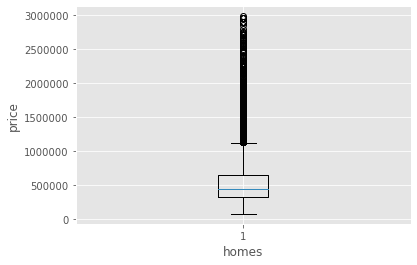

In [64]:
# investigate price outliers
plt.boxplot(train_data['price'])
plt.xlabel('homes')
plt.ylabel('price'); # looks like outliers are probably accurate, but may decrease the model's efficacy

In [8]:
# find 95th percentile of price data
train_data['price'].quantile(0.95)

1170000.0

In [9]:
# look at highest price outliers

data_price_outliers = train_data.loc[data.price >= 1170000].sort_values(by='price', ascending=False)
data_price_outliers.head(500)
data_price_outliers.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,760.00000,760.00000,760.00000,760.00000,760.00000,760.00000,688.00000,757.00000,760.00000,760.00000,760.00000,760.00000,618.00000,760.00000,760.00000,760.00000,760.00000,760.00000,760.00000
mean,4205659171.97500,4.13158,3.28092,3954.68421,22092.81316,1.82961,0.10174,1.39894,3.49211,9.91974,3211.38684,1973.91447,248.88673,98068.97368,47.61906,-122.23154,3129.45263,17341.57368,1713657.89474
std,2817033846.28464,0.91023,0.88811,1235.60161,50436.82774,0.49793,0.30253,1.58678,0.72409,1.17624,1132.64098,33.03078,660.25903,55.18704,0.05672,0.10418,846.85182,27211.22353,639111.94053
min,46100204.00000,1.00000,1.00000,1560.00000,1620.00000,1.00000,0.00000,0.00000,2.00000,6.00000,1040.00000,1900.00000,0.00000,98004.00000,47.32930,-122.41600,1100.00000,1224.00000,1170000.00000
25%,1727850347.50000,4.00000,2.50000,3127.50000,7200.00000,1.50000,0.00000,0.00000,3.00000,9.00000,2370.00000,1951.00000,0.00000,98027.00000,47.58158,-122.29000,2547.50000,6480.00000,1300000.00000
50%,3629915175.00000,4.00000,3.25000,3780.00000,11452.00000,2.00000,0.00000,0.00000,3.00000,10.00000,3040.00000,1984.00000,0.00000,98052.00000,47.62825,-122.22950,3050.00000,10800.00000,1500000.00000
75%,6602500310.50000,5.00000,3.75000,4560.00000,18902.50000,2.00000,0.00000,3.00000,4.00000,11.00000,3880.00000,2003.00000,0.00000,98112.00000,47.64925,-122.19700,3672.50000,17588.00000,1892500.00000
max,9831200520.00000,9.00000,8.00000,13540.00000,881654.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77350,-121.76400,6210.00000,233971.00000,7700000.00000


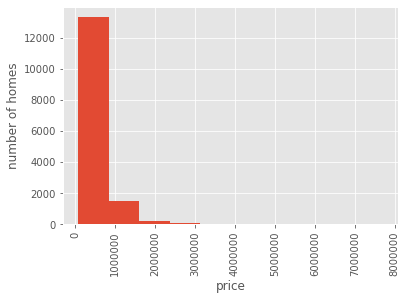

In [10]:
train_data['price'].hist(bins = 10)
plt.xticks(rotation = 'vertical')
plt.xlabel('price')
plt.ylabel('number of homes');

In both the box plot and the histogram above, prices look extremely unusual above $3 million.  There are 36 homes at or above this sale price in the training data.  I will remove these to improve the model later.

In [11]:
# how many homes sold at or above $3 million?

train_data['price'].loc[train_data['price'] >= 3000000].count() #36 homes

36

In [12]:
# drop rows with price > $3 million for training data

train_data = train_data.loc[train_data['price'] < 3000000]
len(train_data)

15081

In [13]:
# make the same change to the test data

test_data = pd.concat([X_test, y_test], axis=1)
test_data['price'].loc[test_data['price'] >= 3000000].count() #15 homes
test_data = test_data.loc[test_data['price'] < 3000000]
len(test_data)

6465

In [14]:
# looking at row detail, max values for bedrooms, bathrooms, sqft_living & sqft_above seem plausible
# but for sqft_living and sqft_above, there is one home with a huge outlier
# same with sqft_lot

# outliers = train_data.sort_values(by='bedrooms', ascending=False).head(500)
# outliers = train_data.sort_values(by='bathrooms', ascending=False).head(500)
# outliers = train_data.sort_values(by='sqft_living', ascending=False).head(500)
# outliers = train_data.sort_values(by='sqft_above', ascending=False).head(500)
outliers = train_data.sort_values(by='sqft_lot', ascending=False).head(500)
outliers

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
1717,1020069017,3/27/2015,4,1.00000,1300,1651359,1.00000,0.00000,3.00000,4,6,1300,0.0,1920,0.00000,98022,47.23130,-122.02300,2560,425581,700000.00000
7640,2623069031,5/21/2014,5,3.25000,3010,1074218,1.50000,nan,0.00000,5,8,2010,1000.0,1931,0.00000,98027,47.45640,-122.00400,2450,68825,542500.00000
7762,2323089009,1/19/2015,4,3.50000,4030,1024068,2.00000,0.00000,0.00000,3,10,4030,0.0,2006,0.00000,98045,47.46190,-121.74400,1830,11700,855000.00000
3945,722069232,9/5/2014,4,3.25000,3770,982998,2.00000,0.00000,0.00000,3,10,3770,0.0,1992,0.00000,98058,47.41400,-122.08700,2290,37141,998000.00000
4437,3626079040,7/30/2014,2,3.00000,2560,982278,1.00000,0.00000,0.00000,3,8,2560,0.0,2004,0.00000,98014,47.69550,-121.86100,1620,40946,790000.00000
7070,2724079090,1/5/2015,4,3.25000,3920,881654,3.00000,nan,3.00000,3,11,3920,?,2002,nan,98024,47.53850,-121.89600,2970,112384,1650000.00000
9705,225079036,1/7/2015,4,4.00000,5545,871200,2.00000,0.00000,0.00000,3,11,3605,1940.0,2003,0.00000,98014,47.67600,-121.88200,3420,871200,937500.00000
4536,2522029039,9/29/2014,3,2.00000,3650,843309,2.00000,0.00000,0.00000,4,7,3650,0.0,1991,nan,98070,47.36270,-122.49600,1870,273992,550000.00000
7287,1923039022,11/20/2014,2,1.75000,1679,577605,2.00000,0.00000,0.00000,3,9,1679,0.0,2001,0.00000,98070,47.46300,-122.47500,1850,358934,700000.00000
2962,2322029048,11/19/2014,3,2.75000,2830,505166,1.00000,1.00000,3.00000,4,8,1830,1000.0,1962,0.00000,98070,47.37820,-122.51400,2120,21988,999000.00000


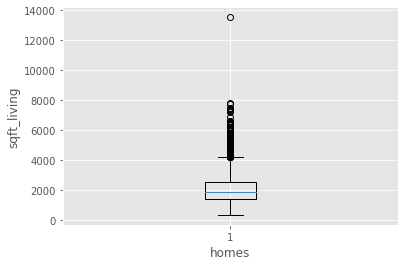

In [15]:
# investigate sqft_living outliers

plt.boxplot(train_data.sqft_living)
plt.xlabel('homes')
plt.ylabel('sqft_living');

# the max value may be accurate, but let's drop it to improve model accuracy

In [16]:
# drop sqft_living > 8000 from training and testing data

train_data = train_data.loc[train_data['sqft_living'] <= 8000]
test_data = test_data.loc[test_data['sqft_living'] <= 8000]

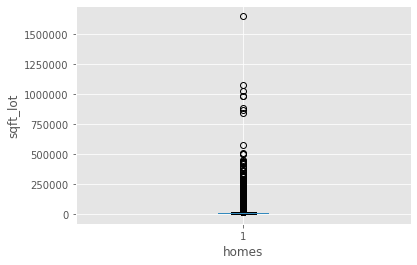

In [17]:
# investigate sqft_lot outliers

plt.boxplot(train_data.sqft_lot)
plt.xlabel('homes')
plt.ylabel('sqft_lot');

# the max values may be accurate, but let's drop them to improve model accuracy

In [18]:
# remove sqft_lot > 600,000 from train and test data

train_data = train_data.loc[train_data['sqft_lot'] <= 600000]
test_data = test_data.loc[test_data['sqft_lot'] <= 600000]

### Null values

Four columns had null values: 'waterfront', 'yr_renovated', 'sqft_basement', and 'view'.  Since fewer than 1% of properties were marked as having waterfront views, I dropped this column from the analysis.  I replaced 'yr_renovated' with a binary column showing whether or not the home was marked renovated in any year.  I replaced the null values in 'sqft_basement' (which appeared as ? in the data) with zeros, since the median of the non-null values in this column was also zero.  Since 'view' refers to the number of times a house had been viewed (not whether it has a nice view), I dropped this column from the analysis.

In [19]:
# investigate null values in waterfront

train_data.waterfront.value_counts() # binary - 1 or 0
train_data.waterfront.isna().sum() #1647 null values out of 21596
train_data.waterfront.value_counts() 

# Only 89 homes are marked as waterfront -- less than 1% of data
# So I'll drop this feature from the analysis

0.00000    13336
1.00000       89
Name: waterfront, dtype: int64

In [20]:
# deal with null values in yr_renovated

train_data['yr_renovated'].value_counts().head(50)
# 11869 values are 0 (meaning no true value)

nulls = train_data['yr_renovated'].isna().sum()
nulls #2692 values are null

# many of the values with years are old, e.g. 1950's-1990's

2692

In [21]:
# create a new column showing homes renovated or not
train_data['renovated'] = np.where(train_data['yr_renovated'] > 0, 1, 0)
train_data['renovated'].value_counts() # only 511 homes show a year renovated

# make same change to testing data
test_data['renovated'] = np.where(test_data['yr_renovated'] > 0, 1, 0)

In [22]:
# deal with non-number values in sqft_basement
train_data['sqft_basement'].value_counts() # continuous variable, but has many '?' values
# also many 0 values.  Not sure if these homes truly do not have basements.

# per cent of data that is missing:
missing_sqft_basement = round((len(train_data.loc[train_data['sqft_basement'] == '?'])/len(train_data))*100, 2)
print(missing_sqft_basement, "% of basement data is missing")

# per cent of data that is zero:
missing_sqft_basement = round((len(train_data.loc[train_data['sqft_basement'] == '0.0'])/len(train_data))*100, 2)
print(missing_sqft_basement, "% of basement data is zero")

2.11 % of basement data is missing
59.37 % of basement data is zero


In [23]:
# for now, let's fill missing values with zero, since that's the median

# replace all '?' values with '0'
train_data.loc[train_data['sqft_basement'] == '?', 'sqft_basement'] = '0'

# same for test data
test_data.loc[test_data['sqft_basement'] == '?', 'sqft_basement'] = '0'

In [24]:
# now convert sqft_basement values to integers

train_data['sqft_basement'] = pd.to_numeric(train_data['sqft_basement'])

test_data['sqft_basement'] = pd.to_numeric(test_data['sqft_basement'])

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15072 entries, 753 to 15795
Data columns (total 22 columns):
id               15072 non-null int64
date             15072 non-null object
bedrooms         15072 non-null int64
bathrooms        15072 non-null float64
sqft_living      15072 non-null int64
sqft_lot         15072 non-null int64
floors           15072 non-null float64
waterfront       13425 non-null float64
view             15029 non-null float64
condition        15072 non-null int64
grade            15072 non-null int64
sqft_above       15072 non-null int64
sqft_basement    15072 non-null float64
yr_built         15072 non-null int64
yr_renovated     12380 non-null float64
zipcode          15072 non-null int64
lat              15072 non-null float64
long             15072 non-null float64
sqft_living15    15072 non-null int64
sqft_lot15       15072 non-null int64
price            15072 non-null float64
renovated        15072 non-null int64
dtypes: float64(9), int64(12), obj

### Exploring Correlations

The analysis below shows that the strongest correlations with price (the target variable) are sqft_living, sqft_above, sqft_living15, grade, and bathrooms.
The strongest correlations between X variables are among these same columns -- all five are correlated with each other.  This multicolinearity could negatively impact a prediction model, so I will experiment with dropping combinations of multicolinear columns later on.
Of all the variables, only grade and bedrooms look normally distributed.  Most are right-skewed, including price.  Later, I will see if log transformations on these variables improve the model.

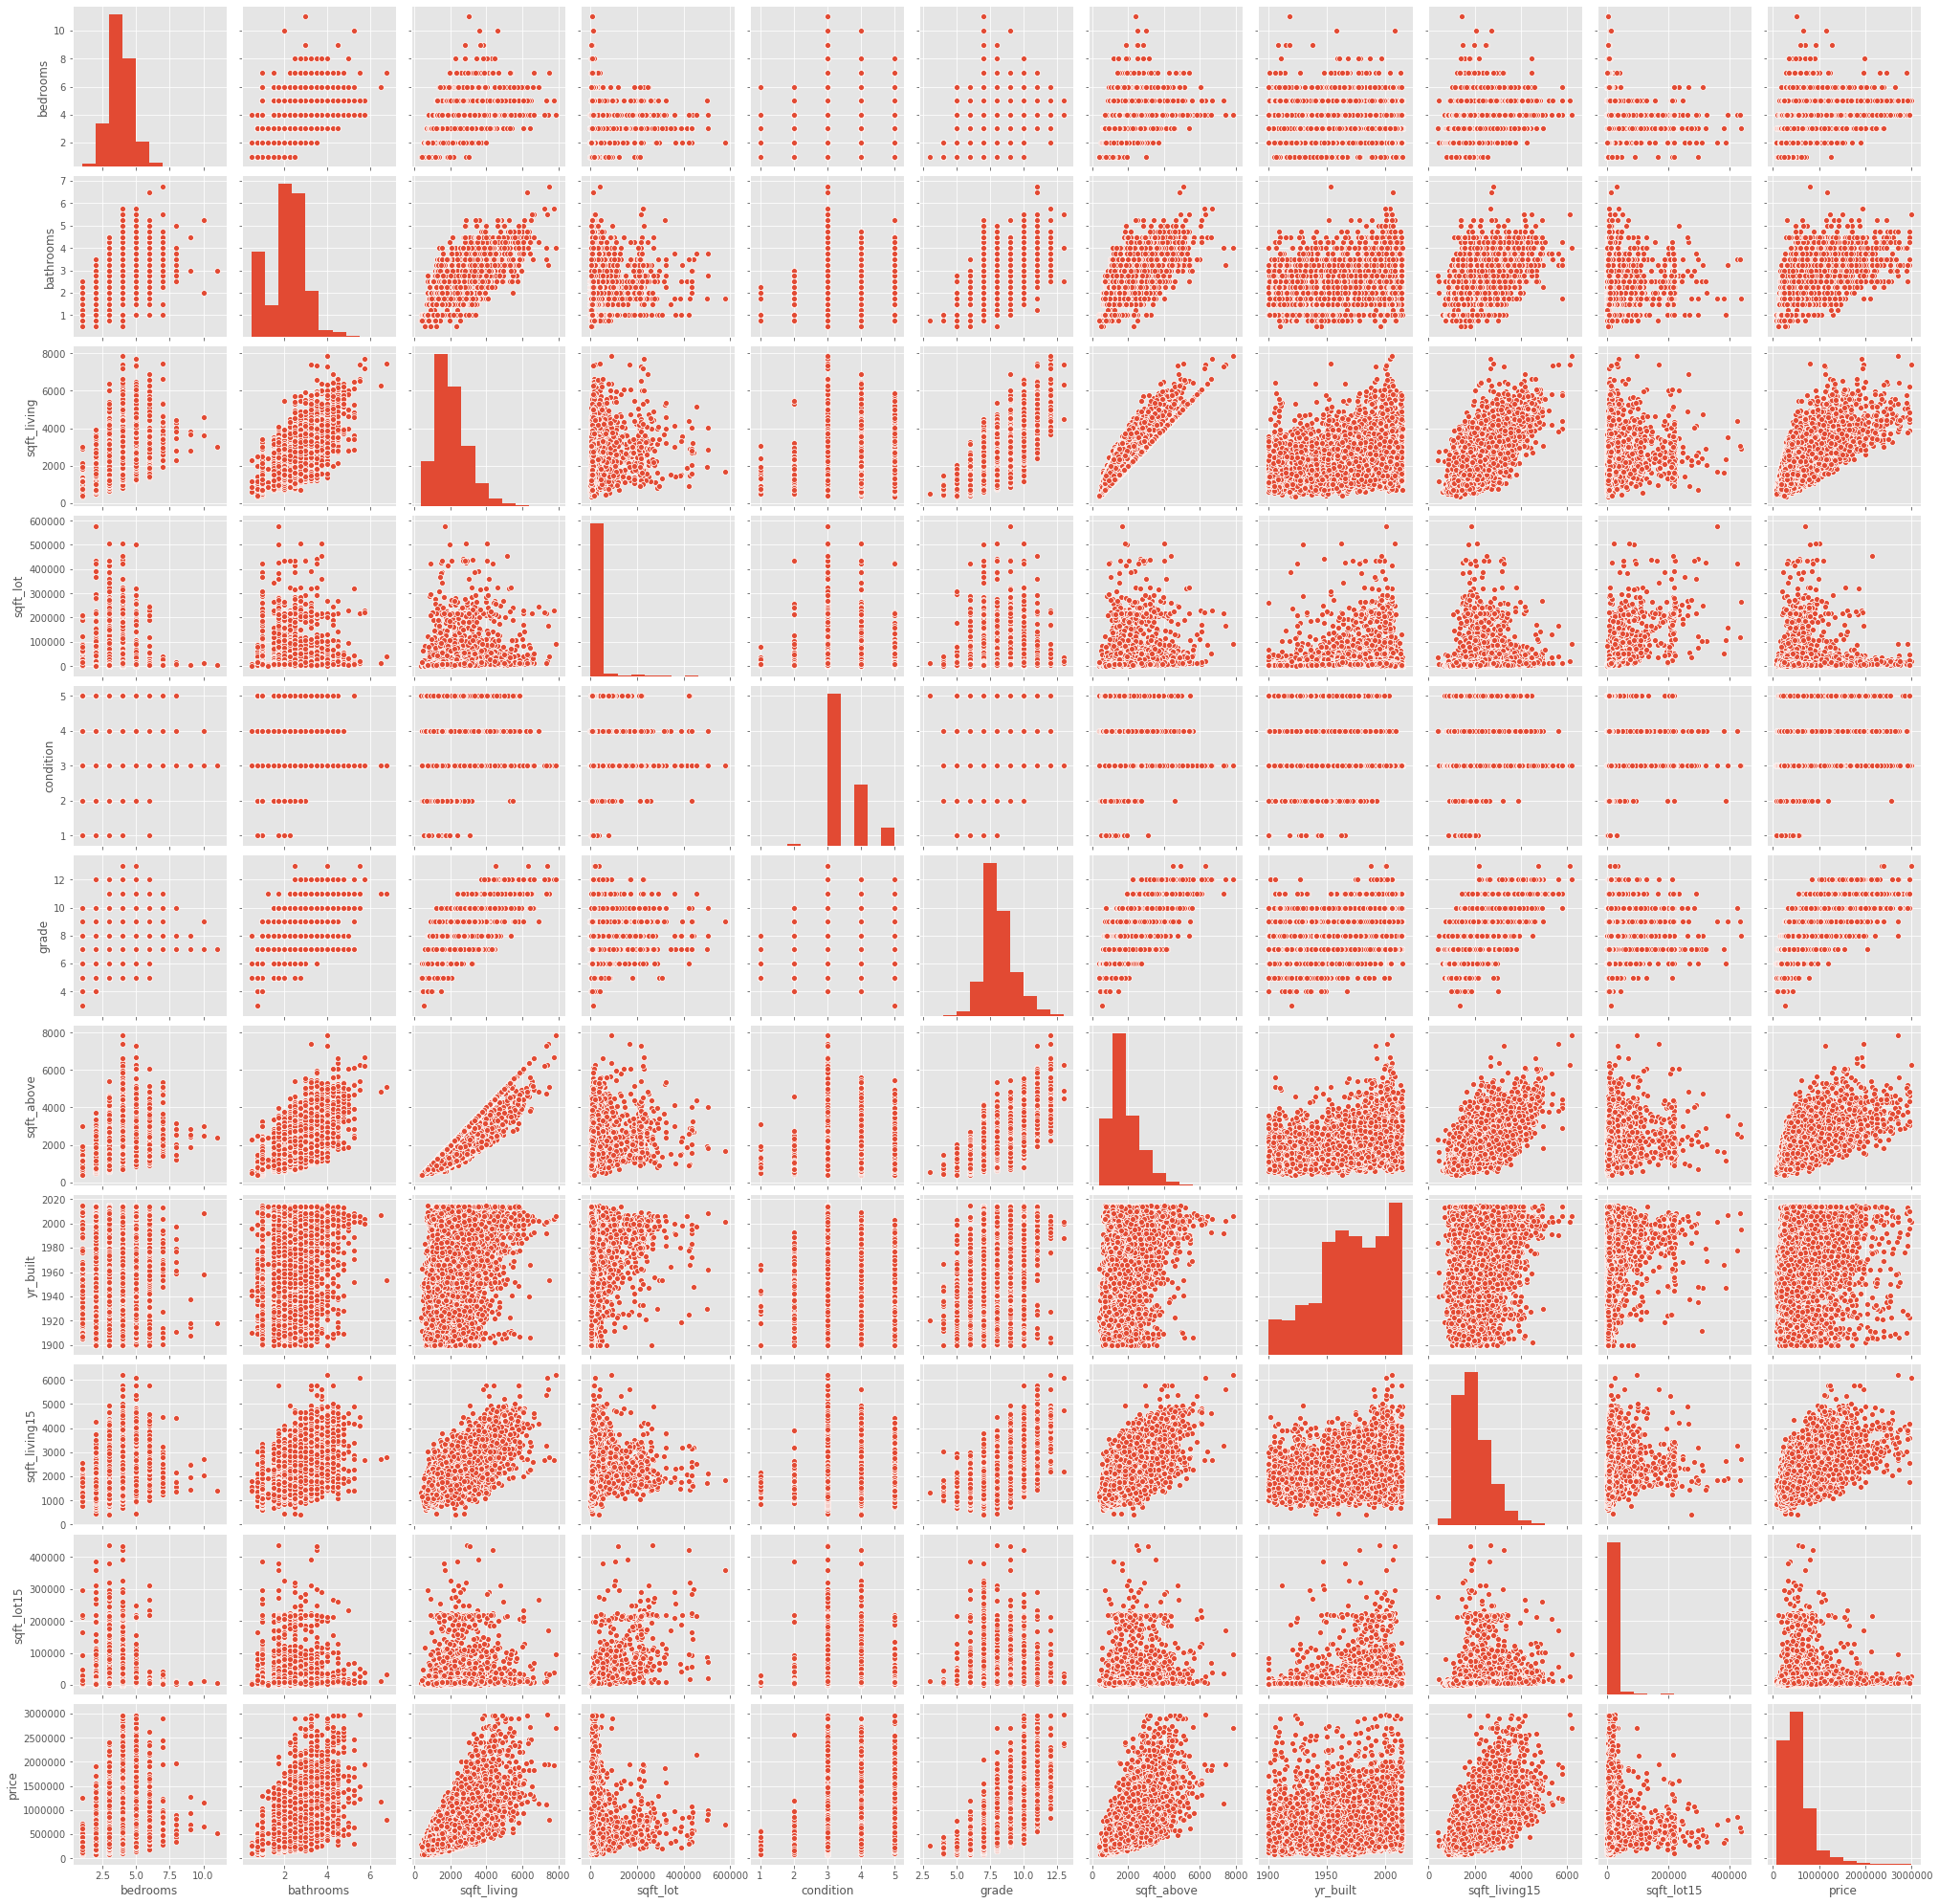

In [25]:
# explore training data
# let's try a pairplot to see if anything stands out

cols_of_interest = [ 
                    'bedrooms', 
                    'bathrooms', 
                    'sqft_living',
                    'sqft_lot', 
                    'condition', 
                    'grade', 
                    'sqft_above',
                    'yr_built',  
                    'sqft_living15', 
                    'sqft_lot15',
                    'price']

sns.pairplot(train_data[cols_of_interest]);

# the strongest correlations with price are sqft_living, sqft_above, sqft_living15, grade, and bathrooms
# strongest correlations between X variables are among these same columns
# only grade and bedrooms look normally distributed

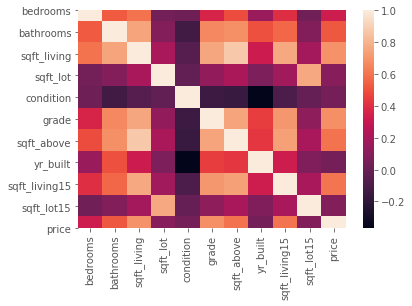

In [26]:
# let's make a heatmap to be sure

sns.heatmap(train_data[cols_of_interest].corr())

# yes, confirms the observations above

In [27]:
# let's look at the numbers

train_data[cols_of_interest].corr()

# sqft_living is the best predictor of price so far

,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price
bedrooms,1.00000,0.52770,0.59653,0.03883,0.01801,0.36141,0.49047,0.15949,0.40267,0.03151,0.32388
bathrooms,0.52770,1.00000,0.75319,0.09375,-0.12716,0.66083,0.68084,0.50416,0.56656,0.08478,0.52305
sqft_living,0.59653,0.75319,1.00000,0.20370,-0.06040,0.75806,0.87374,0.32238,0.76134,0.19124,0.69110
sqft_lot,0.03883,0.09375,0.20370,1.00000,-0.01926,0.13559,0.21213,0.06891,0.17966,0.77070,0.10209
condition,0.01801,-0.12716,-0.06040,-0.01926,1.00000,-0.14761,-0.16191,-0.36453,-0.09209,-0.00618,0.04500
grade,0.36141,0.66083,0.75806,0.13559,-0.14761,1.00000,0.75205,0.44632,0.71063,0.12543,0.68038
sqft_above,0.49047,0.68084,0.87374,0.21213,-0.16191,0.75205,1.00000,0.42744,0.73452,0.20124,0.59729
yr_built,0.15949,0.50416,0.32238,0.06891,-0.36453,0.44632,0.42744,1.00000,0.32377,0.07746,0.04564
sqft_living15,0.40267,0.56656,0.76134,0.17966,-0.09209,0.71063,0.73452,0.32377,1.00000,0.20082,0.60402
sqft_lot15,0.03151,0.08478,0.19124,0.77070,-0.00618,0.12543,0.20124,0.07746,0.20082,1.00000,0.08481


In [28]:
# let's look just at the correlations with price

train_data[cols_of_interest].corr()['price'].sort_values(ascending=False)

# interesting, sqft_living and grade are far above the rest
# grade is probably based in part on sqft_living

price           1.00000
sqft_living     0.69110
grade           0.68038
sqft_living15   0.60402
sqft_above      0.59729
bathrooms       0.52305
bedrooms        0.32388
sqft_lot        0.10209
sqft_lot15      0.08481
yr_built        0.04564
condition       0.04500
Name: price, dtype: float64

### Column Exclusion
Based on the analyses above, I decided to exclude the following columns from the model.  Justifications are provided below:

* id - the randomly assigned house id
* date - date sold, all are between May 2014 and May 2015.  May investigate impact of month later
* waterfront - less than 1% of homes marked as waterfront
* view - number of times the home has been viewed - not relevant for pricing homes newly on the market
* yr_renovated - missing values.  Turned into binary column 'renovated'
* 'lat' and 'long' - latitude and longitude of house - easier to pull location info with zipcode

## Modeling

In this section, I tested nine models, and selected Model 8 as the most effective.  \
\
I first calculated a model-less baseline with an R-squared of 0 and a Mean Absolute Error of \\$227K.  I then tested a baseline linear regression model without transforming any features of the data.  This produced an R-squared of 0.64 and 0.62 for the training and test sets respectively, and Mean Absolute Errors of \\$135K and \\$136K respectively. \
\
After experimenting with log-transforming the X variables and the target variable price, I was able to improve the metrics by log-transforming price, sqft_living15, and sqft_lot15.  By assigning zip codes to price-based classifications, I improved the R-squared to 0.83 for both the training and test data, with Mean Absolute Errors of \\$88K and \\$87K respectively. \
\
I also tested other strategies, such as reducing multicolinearity by dropping columns, omitting features with high p-values, and assigning the yr_built data to categories.  None of these changes improved the model.  However, omitting features with high p-values did reduce the model's effectiveness either, so I kept this change in order to simplify the model.

In [29]:
# split the preprocessed training and test sets back into X and y

# choose relevant columns:

X_train=train_data[['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built', 
       'zipcode',
       'sqft_living15', 
       'sqft_lot15', 
       'renovated']]

y_train=train_data['price']

X_test=test_data[['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built', 
       'zipcode',
       'sqft_living15', 
       'sqft_lot15', 
       'renovated']]

y_test=test_data['price']

print(len(X_train), len(X_test), len(y_train), len(y_test))

15072 6458 15072 6458


### Model 1: Model-less Baseline

In [30]:
# for our first model-less baseline, let's use the mean price
# start with training set

mean_price = y_train.mean()
y_pred_train = np.full(shape=(len(X_train), 1), fill_value=mean_price)

# check r2
r2_baseline_train = round(r2_score(y_true=y_train, y_pred=y_pred_train), 6)

# check Mean Absolute Error
mae_baseline_train = round(mean_absolute_error(y_true=y_train, y_pred=y_pred_train), 2)

# check Root Mean Squared Error
rmse_baseline_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)), 2)

print('Training Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_train, '\n',
      'Mean Absolute Error:', mae_baseline_train, '\n',
      'Root Mean Squared Error:', rmse_baseline_train)

Training Data 
 Mean Price: 534162.34 
 R-Squared: 0.0 
 Mean Absolute Error: 226613.15 
 Root Mean Squared Error: 331365.24


In [31]:
# now let's calculate baseline r2, MAE, and RMSE for the test set

y_pred_test = np.full(shape=(len(X_test), 1), fill_value=mean_price)

r2_baseline_test = round(r2_score(y_true=y_test, y_pred=y_pred_test), 6)
mae_baseline_test = round(mean_absolute_error(y_true=y_test, y_pred=y_pred_test), 2)
rmse_baseline_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test)), 2)

print('Testing Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_test, '\n',
      'Mean Absolute Error:', mae_baseline_test, '\n',
      'Root Mean Squared Error:', rmse_baseline_test)

Testing Data 
 Mean Price: 534162.34 
 R-Squared: -0.000468 
 Mean Absolute Error: 221118.2 
 Root Mean Squared Error: 315393.0


In [32]:
# create a function for evaluating models:

def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # check train r2
    r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 6)

    # check train Mean Absolute Error
    mae_train = round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred), 2)

    # check train Root Mean Squared Error
    rmse_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_pred)), 2)

    print('Training Data', '\n', 
          'R-Squared:', r2_train, '\n',
          'Mean Absolute Error:', mae_train, '\n',
          'Root Mean Squared Error:', rmse_train, '\n')
    
    # check test r2
    r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 6)

    # check test Mean Absolute Error
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred), 2)

    # check train Root Mean Squared Error
    rmse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred)), 2)

    print('Testing Data', '\n', 
          'R-Squared:', r2_test, '\n',
          'Mean Absolute Error:', mae_test, '\n',
          'Root Mean Squared Error:', rmse_test)

In [33]:
# the mean is not a good predictor of price!

# let's fit a baseline regression model

### Model 2: Baseline Linear Regression

In [34]:
# first, let's scale the data so we can evaluate the coefficients of the baseline model

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# now do a linear regression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_pred2 = linreg.predict(X_train_scaled)
y_test_pred2 = linreg.predict(X_test_scaled)

evaluate_model(y_train, y_train_pred2, y_test, y_test_pred2)

Training Data 
 R-Squared: 0.635164 
 Mean Absolute Error: 135333.41 
 Root Mean Squared Error: 200150.17 

Testing Data 
 R-Squared: 0.618171 
 Mean Absolute Error: 135514.39 
 Root Mean Squared Error: 194842.99


In [36]:
# that's better, but the model still only explains about 60% of the variance
# store as 'best_r2' for comparison

best_r2 = {'train': 0.635164, 'test': 0.618171}

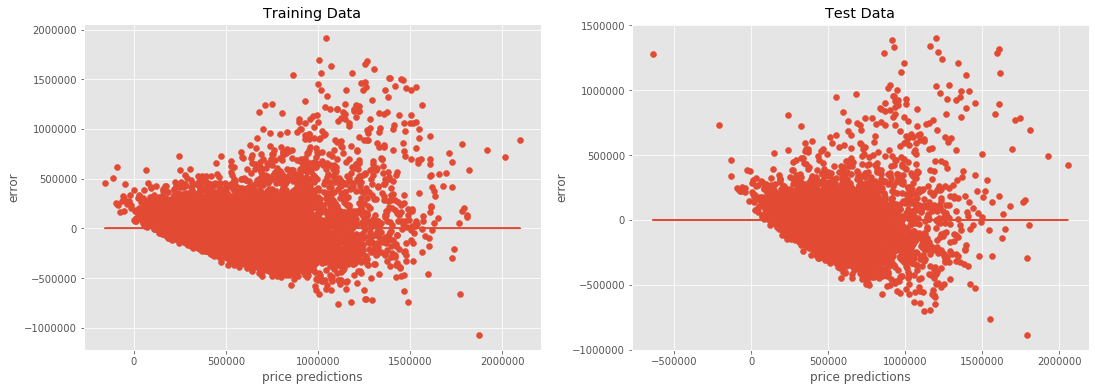

In [37]:
# let's plot training set residuals

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))

residuals_train = y_train-y_train_pred2
ax1 = plt.subplot(121)
ax1.scatter(y_train_pred2, residuals_train)
ax1.plot(y_train_pred2, [0 for i in range(len(y_train_pred2))])
plt.title('Training Data')
plt.xlabel('price predictions')
plt.ylabel('error')

residuals_test = y_test-y_test_pred2
ax2 = plt.subplot(122)
ax2.scatter(y_test_pred2, residuals_test)
ax2.plot(y_test_pred2, [0 for i in range(len(y_test_pred2))])
plt.title('Test Data')
plt.xlabel('price predictions')
plt.ylabel('error');

# cone-shaped residuals indicate heteroskedasticity
# means that as price increases, error increases as well
# will try log transformations to reduce the effect of outliers

In [38]:
# run it in Statsmodels to check coefficients

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)))
results = model.fit()

results.summary()

# same R-squared as above
# sqft_lot and sqft_above have p-values above 0.05.  Experiment with removing these later

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1872.
Date:                Sat, 30 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:37:02   Log-Likelihood:            -2.0537e+05
No. Observations:               15072   AIC:                         4.108e+05
Df Residuals:                   15057   BIC:                         4.109e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.342e+05   1631.123    327.481      0.000    5.31e+05    5.37e+05
bedrooms      -3.373e+04   2129.912    -15.834      0.000   -3.79e+04   -2.96e+04
bathrooms       3.44e+04   2978.015     11.551      0.000    2.86e+04    4.02e+04
sqft_living    9.403e+04   1.97e+04      4.765      0.000    5.53e+04    1.33e+05
sqft_lot        675.6564   2584.241      0.261      0.794   -4389.771    5741.084
floors         2.328e+04   2308.084     10.087      0.000    1.88e+04    2.78e+04
condition      1.622e+04   1816.099      8.931      0.000    1.27e+04    1.98e+04
grade          1.448e+05   2908.904     49.788      0.000    1.39e+05    1.51e+05
sqft_above     1.147e+04   1.79e+04      0.639      0.523   -2.37e+04    4.66e+04
sqft_basement  2.053e+04   9471.972      2.168      0.030    1966.229    3.91e+04
yr_built       -1.08e+05   2391.705    -45.136      0.000   -1.13e+05   -1.03e+05
zipcode        7009.9545   1851.959      3.785      0.000    3379.890    1.06e+04
sqft_living15  4.159e+04   2767.834     15.027      0.000    3.62e+04     4.7e+04
sqft_lot15    -1.154e+04   2584.213     -4.466      0.000   -1.66e+04   -6474.869
renovated      7959.0619   1718.238      4.632      0.000    4591.106    1.13e+04
==============================================================================
Omnibus:                     7051.516   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79640.454
Skew:                           1.959   Prob(JB):                         0.00
Kurtosis:                      13.557   Cond. No.                         38.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3: 7 Log-Transformed X Variables

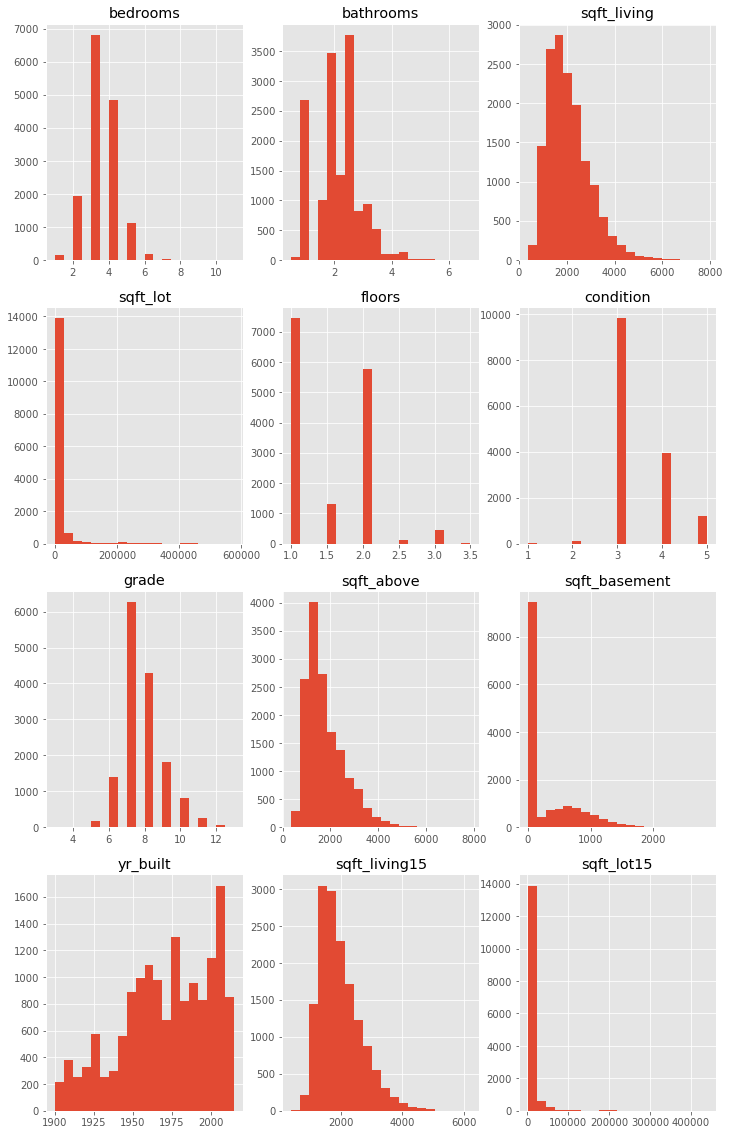

In [39]:
# let's look at the numeric variables.  Are they normally distributed?

numeric = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

num_cols = 3
if len(numeric)%num_cols == 0:
    num_rows = len(numeric)//num_cols
else:
    num_rows = (len(numeric)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in numeric:
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].hist(X_train[feat], bins=20)
    axs[numeric.index(feat)//num_cols, numeric.index(feat)%num_cols].set_title(feat)

In [40]:
# numeric variables are not normally distributed
# let's try to log these and see if they become more normal
# don't include features with zeros, like sqft_basement

non_zero = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train_logged = X_train.copy()

for feat in non_zero:
    X_train_logged[feat] = X_train_logged[feat].map(lambda x: np.log(x))


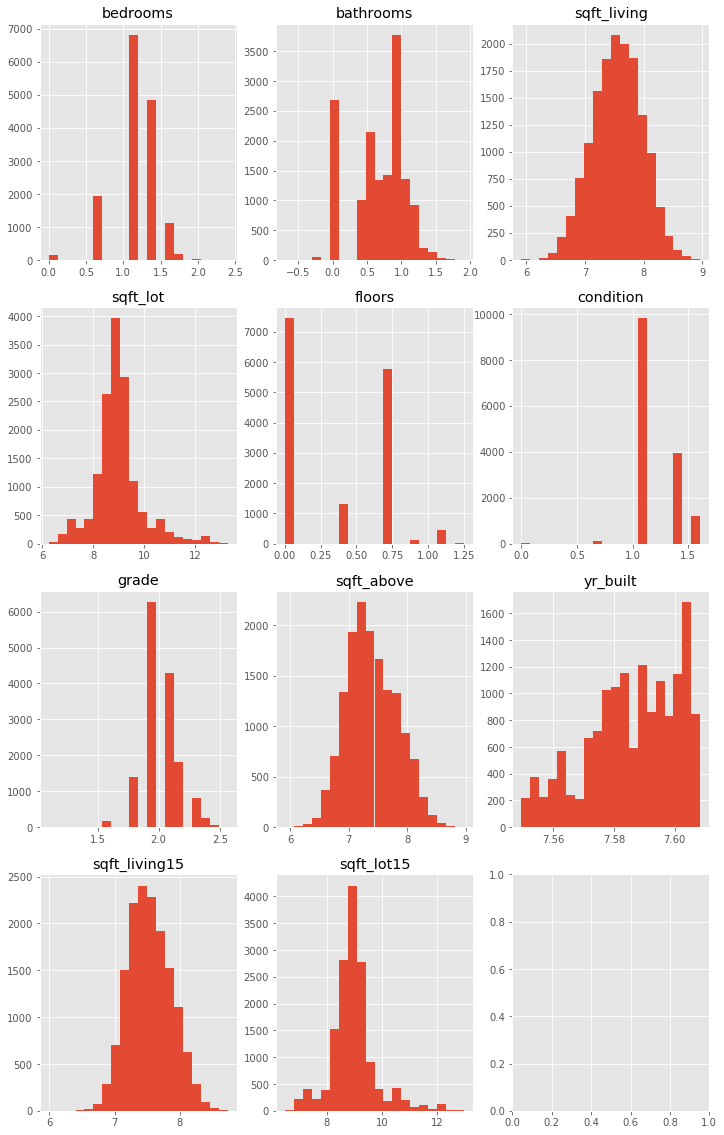

In [41]:
# Did it help?  Make more histograms

num_cols = 3
if len(non_zero)%num_cols == 0:
    num_rows = len(non_zero)//num_cols
else:
    num_rows = (len(non_zero)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for feat in non_zero:
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].hist(X_train_logged[feat], bins=20)
    axs[non_zero.index(feat)//num_cols, non_zero.index(feat)%num_cols].set_title(feat)

In [42]:
# it helped - some variables look more normally distributed
# like sqft_living, sqft_lot, grade, sqft_above, sqft_living15, sqft_lot15
# and to a lesser extent, bedrooms and grade too

In [43]:
# what if we build a model with just the above columns logged

# build a new X_train with just the above features logged

to_log = ['bedrooms', 
       'sqft_living', 
       'sqft_lot', 
       'grade',
       'sqft_above', 
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train3 = X_train.copy()

for feat in to_log:
    X_train3[feat] = X_train3[feat].map(lambda x: np.log(x))
    
# log the test data

X_test3 = X_test.copy()

for feat in to_log:
    X_test3[feat] = X_test3[feat].map(lambda x: np.log(x))

In [44]:
# build a function to scale the X variables, and do a linear regression

def scale_lin_reg(X_train, y_train, X_test):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    y_train_pred = linreg.predict(X_train_scaled)
    y_test_pred = linreg.predict(X_test_scaled)
        
    return(y_train_pred, y_test_pred)

In [45]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train3 and X_test3 have 7 features logged

y_train_pred3, y_test_pred3 = scale_lin_reg(X_train=X_train3, y_train=y_train, X_test=X_test3)

In [46]:
# now let's evaluate that model
evaluate_model(y_train=y_train, y_train_pred=y_train_pred3, y_test=y_test, y_test_pred=y_test_pred3)

Training Data 
 R-Squared: 0.604166 
 Mean Absolute Error: 140699.83 
 Root Mean Squared Error: 208479.59 

Testing Data 
 R-Squared: 0.584709 
 Mean Absolute Error: 140646.01 
 Root Mean Squared Error: 203201.36


In [47]:
best_r2

# oh no!  It didn't help!  R2 got worse

{'train': 0.635164, 'test': 0.618171}

### Model 4: 2 Logged X Variables

In [48]:
# these two features have the most improvement in normality after log transformations:
# sqft_living15
# sqft_lot15

# what if we just log these?

to_log = [
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train4 = X_train.copy()

for feat in to_log:
    X_train4[feat] = X_train4[feat].map(lambda x: np.log(x))

# log the test data

X_test4 = X_test.copy()

for feat in to_log:
    X_test4[feat] = X_test4[feat].map(lambda x: np.log(x))

In [49]:
# let's scale and do a linear regression on the transformed data, to return y_train_pred and y_test_pred
# the inputs X_train4 and X_test4 have 2 features logged

y_train_pred4, y_test_pred4 = scale_lin_reg(X_train=X_train4, y_train=y_train, X_test=X_test4)

In [50]:
# evaluate the model

evaluate_model(y_train=y_train, y_train_pred=y_train_pred4, y_test=y_test, y_test_pred=y_test_pred4)

Training Data 
 R-Squared: 0.635315 
 Mean Absolute Error: 134720.89 
 Root Mean Squared Error: 200108.55 

Testing Data 
 R-Squared: 0.62024 
 Mean Absolute Error: 134413.73 
 Root Mean Squared Error: 194314.5


In [51]:
best_r2

# That is a very slight improvement over the baseline model
# Price (target variable) was also right-skewed.  Let's try logging this as well.

{'train': 0.635164, 'test': 0.618171}

### Model 5: Two Logged X Variables and Logged Target Variable

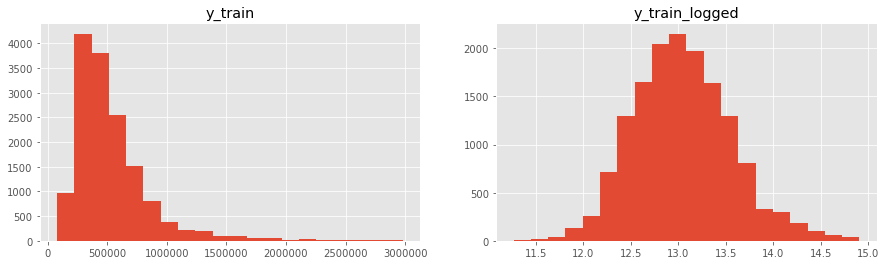

In [52]:
y_train_logged = y_train.copy()
y_train_logged = y_train_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_train, bins=20)
ax[0].set_title('y_train')

ax[1].hist(y_train_logged, bins=20)
ax[1].set_title('y_train_logged');

# the logged y_train definitely looks more normally distributed

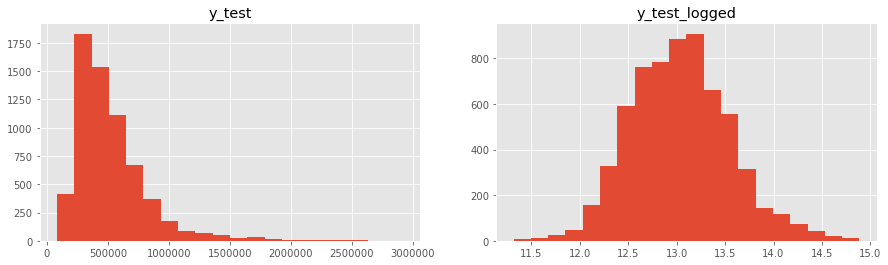

In [53]:
# log y_test as well

y_test_logged = y_test.copy()
y_test_logged = y_test_logged.map(lambda y: np.log1p(y))

fig, ax = plt.subplots(figsize = (15,4), nrows=1, ncols=2)

ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')

ax[1].hist(y_test_logged, bins=20)
ax[1].set_title('y_test_logged');

# the logged y_test looks more normally distributed too

In [54]:
# now let's run and evaluate the model with X_train4, X_test4, y_train_logged and y_test_logged

y_train_pred5, y_test_pred5 = scale_lin_reg(X_train=X_train4, y_train=y_train_logged, X_test=X_test4)

In [55]:
# create a function to only evaluate R-squared, since MAE and RMSE must use unlogged price predictions

def eval_r2(y_train, y_train_pred, y_test, y_test_pred):

    # calculate r2 using logged target variable
    r2_train = round(r2_score(y_true=y_train, y_pred=y_train_pred), 6)
    r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 6)

    print('Training Data', '\n', 
          'R-Squared:', r2_train, '\n')
    
    print('Test Data', '\n', 
          'R-Squared:', r2_test)

In [56]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred5, y_test=y_test_logged, y_test_pred=y_test_pred5)

Training Data 
 R-Squared: 0.656332 

Test Data 
 R-Squared: 0.62867


In [57]:
# great, it helped a little, but need to unlog y_train_pred5 and y_test_pred5 to measure price errors

# create a function to unlog predictions and measure MAE and RMSE
def unlog_MAE_RMSE(y_train, y_train_logged_pred, y_test, y_test_logged_pred):
    
    # unlog target variable predictions to measure MAE and RMSE
    y_train_pred_exp = np.expm1(y_train_logged_pred)
    y_test_pred_exp = np.expm1(y_test_logged_pred)
    
    # check Mean Absolute Error
    mae_train = round(mean_absolute_error(y_true=y_train, y_pred=y_train_pred_exp), 2)
    mae_test = round(mean_absolute_error(y_true=y_test, y_pred=y_test_pred_exp), 2)

    # check Root Mean Squared Error
    rmse_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_pred_exp)), 2)
    rmse_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred_exp)), 2)

    print('Training Data', '\n', 
          'Mean Absolute Error:', mae_train, '\n',
          'Root Mean Squared Error:', rmse_train, '\n')
    
    print('Test Data', '\n', 
          'Mean Absolute Error:', mae_test, '\n',
          'Root Mean Squared Error:', rmse_test, '\n')

In [58]:
unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred5, y_test=y_test, y_test_logged_pred=y_test_pred5)

Training Data 
 Mean Absolute Error: 126748.86 
 Root Mean Squared Error: 196464.59 

Test Data 
 Mean Absolute Error: 128505.75 
 Root Mean Squared Error: 195365.54 



In [59]:
# update best_r2

best_r2['train'] = 0.656332
best_r2['test'] = 0.62867

### Model 6: Two Logged X Variables, Logged Target Variable, and Zip Code Categories

In [60]:
# let's try to assign zip codes to price categories

X_train6 = X_train4.copy() # use X_train4, which had two features logged

X_train6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15072 entries, 753 to 15795
Data columns (total 14 columns):
bedrooms         15072 non-null int64
bathrooms        15072 non-null float64
sqft_living      15072 non-null int64
sqft_lot         15072 non-null int64
floors           15072 non-null float64
condition        15072 non-null int64
grade            15072 non-null int64
sqft_above       15072 non-null int64
sqft_basement    15072 non-null float64
yr_built         15072 non-null int64
zipcode          15072 non-null int64
sqft_living15    15072 non-null float64
sqft_lot15       15072 non-null float64
renovated        15072 non-null int64
dtypes: float64(5), int64(9)
memory usage: 1.7 MB


In [61]:
X_train6['zipcode'].value_counts().count() # 70 different zips
X_train6['zipcode'].value_counts()

98103    441
98052    418
98115    402
98038    401
98034    392
98117    380
98042    372
98133    361
98023    361
98118    334
98006    329
98059    321
98058    313
98155    306
98027    305
98074    301
98125    294
98033    293
98056    279
98053    271
98075    269
98001    255
98126    241
98092    235
98106    232
98116    229
98144    229
98199    229
98029    220
98065    217
98004    207
98122    205
98055    201
98198    196
98031    195
98112    195
98008    195
98072    194
98003    194
98028    193
98168    190
98040    189
98178    189
98166    187
98146    186
98136    184
98177    180
98107    178
98030    171
98105    162
98045    161
98022    152
98108    142
98077    138
98002    133
98011    133
98019    131
98119    130
98005    119
98188    102
98007     97
98014     92
98032     82
98010     78
98070     77
98102     76
98109     71
98024     59
98148     44
98039     34
Name: zipcode, dtype: int64

In [62]:
zips=pd.concat([X_train6['zipcode'], pd.DataFrame(y_train)['price']], axis=1)
zips

,zipcode,price
753,98053,699800.00000
1418,98178,1700000.00000
8178,98003,258000.00000
2254,98022,245000.00000
4063,98055,373000.00000
...,...,...
11964,98065,440000.00000
21575,98178,572000.00000
5390,98014,299800.00000
860,98168,245000.00000


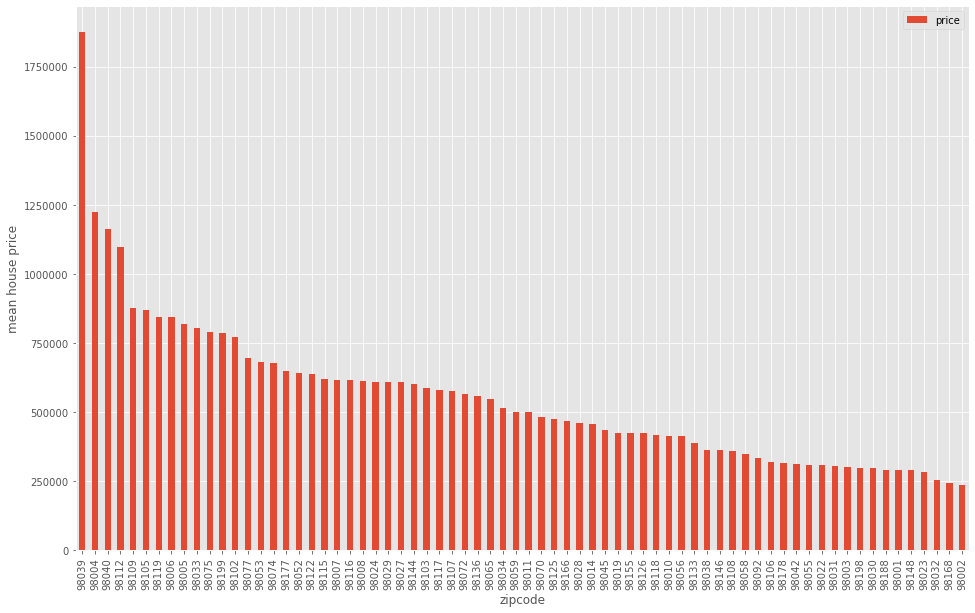

In [63]:
# find mean price by zip to see if any stand out

zips_pivot = zips.pivot_table(values='price', index='zipcode', ).sort_values(by='price', ascending=False)
zips_pivot.plot(kind='bar', figsize=(16,10))
plt.ylabel('mean house price')
plt.legend;

plt.savefig('price_by_zip_code')

# yes, some do stand out!  the top four, the bottom three
# what if I classified them based on price? I can make a dictionary

In [409]:
# create a dictionary of zip codes and classifications

ordered_zip_list = list(zips_pivot.index)
zip_dict = {}

# display all zips and index in price-ordered list for eyeballing

for i in ordered_zip_list:
    print(i, ordered_zip_list.index(i))

98039 0
98004 1
98040 2
98112 3
98109 4
98105 5
98119 6
98006 7
98005 8
98033 9
98075 10
98199 11
98102 12
98077 13
98053 14
98074 15
98177 16
98052 17
98122 18
98115 19
98007 20
98116 21
98008 22
98024 23
98029 24
98027 25
98144 26
98103 27
98117 28
98107 29
98072 30
98136 31
98065 32
98034 33
98059 34
98011 35
98070 36
98125 37
98166 38
98028 39
98014 40
98045 41
98019 42
98155 43
98126 44
98118 45
98010 46
98056 47
98133 48
98038 49
98146 50
98108 51
98058 52
98092 53
98106 54
98178 55
98042 56
98055 57
98022 58
98031 59
98003 60
98198 61
98030 62
98188 63
98001 64
98148 65
98023 66
98032 67
98168 68
98002 69


In [410]:
# classify zips in dict:

zip_dict[ordered_zip_list[0]] = 'Zip Class 1'

# make a function to add entries more easily
def add_to_zip_dict(list_index_start, list_index_stop, category):
    for i in ordered_zip_list[list_index_start:list_index_stop]:
        zip_dict[i] = category

add_to_zip_dict(1, 4, 'Zip Class 2')
add_to_zip_dict(4, 13, 'Zip Class 3')
add_to_zip_dict(13, 34, 'Zip Class 4')
add_to_zip_dict(34, 49, 'Zip Class 5')
add_to_zip_dict(49, 67, 'Zip Class 6')
add_to_zip_dict(67, 70, 'Zip Class 7')

zip_dict

{98039: 'Zip Class 1',
 98004: 'Zip Class 2',
 98040: 'Zip Class 2',
 98112: 'Zip Class 2',
 98109: 'Zip Class 3',
 98105: 'Zip Class 3',
 98119: 'Zip Class 3',
 98006: 'Zip Class 3',
 98005: 'Zip Class 3',
 98033: 'Zip Class 3',
 98075: 'Zip Class 3',
 98199: 'Zip Class 3',
 98102: 'Zip Class 3',
 98077: 'Zip Class 4',
 98053: 'Zip Class 4',
 98074: 'Zip Class 4',
 98177: 'Zip Class 4',
 98052: 'Zip Class 4',
 98122: 'Zip Class 4',
 98115: 'Zip Class 4',
 98007: 'Zip Class 4',
 98116: 'Zip Class 4',
 98008: 'Zip Class 4',
 98024: 'Zip Class 4',
 98029: 'Zip Class 4',
 98027: 'Zip Class 4',
 98144: 'Zip Class 4',
 98103: 'Zip Class 4',
 98117: 'Zip Class 4',
 98107: 'Zip Class 4',
 98072: 'Zip Class 4',
 98136: 'Zip Class 4',
 98065: 'Zip Class 4',
 98034: 'Zip Class 4',
 98059: 'Zip Class 5',
 98011: 'Zip Class 5',
 98070: 'Zip Class 5',
 98125: 'Zip Class 5',
 98166: 'Zip Class 5',
 98028: 'Zip Class 5',
 98014: 'Zip Class 5',
 98045: 'Zip Class 5',
 98019: 'Zip Class 5',
 98155: 'Zi

In [411]:
# add classification column to training data

X_train6['zip_class'] = X_train6['zipcode'].map(lambda x: zip_dict[x])
X_train6

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,zip_class
753,2,2.50000,2380,6600,1.00000,3,8,2380,0.00000,2010,98053,7.53369,8.79482,0,Zip Class 4
1418,4,3.75000,3190,17186,2.00000,3,10,3190,0.00000,1999,98178,7.73631,9.51015,0,Zip Class 6
8178,3,2.50000,1730,6930,2.00000,3,8,1730,0.00000,1994,98003,7.48437,8.84362,0,Zip Class 6
2254,4,2.00000,1870,8750,1.00000,3,7,1870,0.00000,1977,98022,7.47873,9.01274,0,Zip Class 6
4063,8,3.00000,2850,12714,1.00000,3,7,2850,0.00000,1959,98055,7.29980,8.50553,0,Zip Class 6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50000,2230,5800,2.00000,3,7,2230,0.00000,2004,98065,7.70976,8.71407,0,Zip Class 4
21575,4,2.75000,2770,3852,2.00000,3,8,2770,0.00000,2014,98178,7.50108,8.63782,0,Zip Class 6
5390,4,1.50000,1530,9000,1.00000,4,6,1530,0.00000,1976,98014,7.32647,9.04782,0,Zip Class 5
860,1,0.75000,380,15000,1.00000,3,5,380,0.00000,1963,98168,7.06476,9.61581,0,Zip Class 7


In [412]:
# one hot encode classification column and drop zipcode and zip_class columns

zip_class_columns = pd.get_dummies(X_train6['zip_class'], drop_first=True)
zip_class_columns

X_train6 = pd.concat([X_train6, zip_class_columns], axis=1)
X_train6.drop(columns=['zipcode','zip_class'], inplace=True)

In [413]:
# add same features to test set

X_test6 = X_test4
X_test6['zip_class'] = X_test6['zipcode'].map(lambda x: zip_dict[x])

zip_class_columns = pd.get_dummies(X_test6['zip_class'], drop_first=True)
X_test6 = pd.concat([X_test6, zip_class_columns], axis=1)
X_test6.drop(columns=['zipcode','zip_class'], inplace=True)

In [414]:
X_train6 #looks good
X_test6 #looks good

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7
3686,3,0.75000,850,8573,1.00000,3,6,600,250.00000,1945,6.74524,9.03384,0,0,0,0,0,1,0
10247,3,1.00000,1510,6083,1.00000,4,6,860,650.00000,1940,7.31986,8.65032,0,0,0,1,0,0,0
4037,4,2.25000,1790,42000,1.00000,3,7,1170,620.00000,1983,7.63046,10.82166,0,0,0,0,1,0,0
3437,2,1.50000,1140,2500,1.00000,3,7,630,510.00000,1988,7.31322,8.51719,0,0,0,0,0,1,0
19291,3,1.00000,1500,3920,1.00000,3,7,1000,500.00000,1947,7.40245,8.29829,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9400,4,3.50000,2650,3060,2.00000,3,9,2060,590.00000,2001,7.29302,8.02617,0,0,0,1,0,0,0
9092,4,2.75000,2670,6780,2.00000,5,8,1630,1040.00000,1908,7.78322,8.69768,0,0,0,0,1,0,0
6650,3,1.75000,1600,10280,1.00000,3,7,1050,550.00000,1977,7.37149,8.99962,0,0,0,1,0,0,0
21095,5,3.50000,2760,3865,2.50000,3,8,2760,0.00000,2013,7.85941,8.43098,0,0,0,0,1,0,0


In [415]:
# generate predictions

y_train_pred6, y_test_pred6 = scale_lin_reg(X_train=X_train6, y_train=y_train_logged, X_test=X_test6)

In [416]:
# evaluate model using R-squared

eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred6, y_test=y_test_logged, y_test_pred=y_test_pred6)

Training Data 
 R-Squared: 0.831058 

Test Data 
 R-Squared: 0.825734


In [417]:
# to evaluate MAE and RMSE, unlog y_train_pred6 and y_test_pred6

unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred6, y_test=y_test, y_test_logged_pred=y_test_pred6)

Training Data 
 Mean Absolute Error: 88248.13 
 Root Mean Squared Error: 151546.53 

Test Data 
 Mean Absolute Error: 86914.78 
 Root Mean Squared Error: 144785.38 



In [418]:
# great, this really helped!
# update best_r2

best_r2 = {'train': 0.831058, 'test': 0.825734}

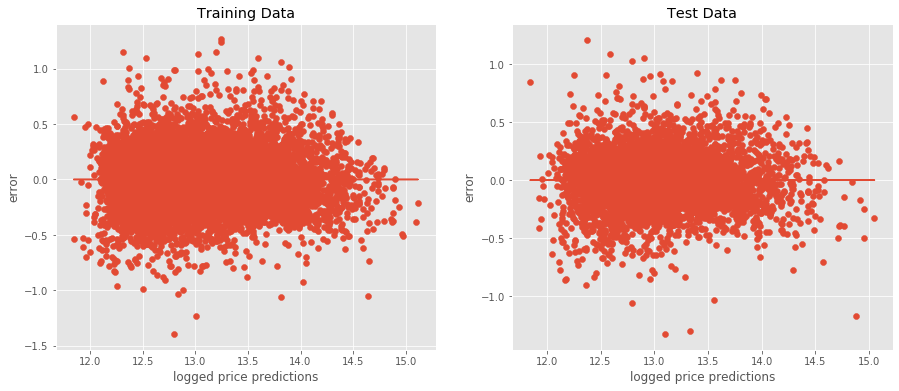

In [419]:
# let's look at the training set residuals:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

residuals_train6 = y_train_logged-y_train_pred6
ax1 = plt.subplot(121)
plt.scatter(y_train_pred6, residuals_train6)
plt.plot(y_train_pred6, [0 for i in range(len(y_train_pred6))])
plt.title('Training Data')
plt.xlabel('logged price predictions')
plt.ylabel('error')

residuals_test6 = y_test_logged-y_test_pred6
ax2 = plt.subplot(122)
plt.scatter(y_test_pred6, residuals_test6)
plt.plot(y_test_pred6, [0 for i in range(len(y_test_pred6))])
plt.title('Test Data')
plt.xlabel('logged price predictions')
plt.ylabel('error');

# looks better than the cone shape

In [420]:
# look at coefficients

model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train6, columns=X_train6.columns, index=X_train6.index)))
results = model.fit()

results.summary()

# sqft_above and sqft_basement have high p-values
# experiment with removing these later

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     3897.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:04:01   Log-Likelihood:                 1910.3
No. Observations:               15072   AIC:                            -3781.
Df Residuals:                   15052   BIC:                            -3628.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.9820      0.174     97.653      0.000      16.641      17.323
bedrooms         -0.0149      0.003     -5.956      0.000      -0.020      -0.010
bathrooms         0.0548      0.004     13.012      0.000       0.047       0.063
sqft_living       0.0002   2.35e-05      7.555      0.000       0.000       0.000
sqft_lot       8.706e-07   7.08e-08     12.305      0.000    7.32e-07    1.01e-06
floors            0.0253      0.005      5.090      0.000       0.016       0.035
condition         0.0416      0.003     14.037      0.000       0.036       0.047
grade             0.1188      0.003     43.040      0.000       0.113       0.124
sqft_above    -2.888e-06   2.34e-05     -0.123      0.902   -4.88e-05     4.3e-05
sqft_basement  6.476e-06   2.33e-05      0.278      0.781   -3.91e-05    5.21e-05
yr_built         -0.0028    8.6e-05    -33.017      0.000      -0.003      -0.003
sqft_living15     0.1610      0.009     18.181      0.000       0.144       0.178
sqft_lot15       -0.0351      0.003    -10.077      0.000      -0.042      -0.028
renovated         0.0746      0.010      7.364      0.000       0.055       0.094
Zip Class 2      -0.2860      0.038     -7.580      0.000      -0.360      -0.212
Zip Class 3      -0.4974      0.037    -13.405      0.000      -0.570      -0.425
Zip Class 4      -0.6171      0.037    -16.706      0.000      -0.689      -0.545
Zip Class 5      -0.8223      0.037    -22.183      0.000      -0.895      -0.750
Zip Class 6      -1.1048      0.037    -29.815      0.000      -1.177      -1.032
Zip Class 7      -1.2159      0.038    -31.593      0.000      -1.291      -1.140
==============================================================================
Omnibus:                      832.303   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3064.888
Skew:                           0.156   Prob(JB):                         0.00
Kurtosis:                       5.187   Cond. No.                     3.65e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [421]:
# which coefficients are most closely correlated with price?
X_train6.corrwith(y_train_logged).sort_values(ascending=False)

# grade and sqft_living, as in the original data

grade            0.69756
sqft_living      0.68763
sqft_living15    0.60771
sqft_above       0.59249
bathrooms        0.54577
bedrooms         0.34674
Zip Class 3      0.33063
Zip Class 2      0.32369
floors           0.30996
sqft_basement    0.29778
Zip Class 4      0.28168
sqft_lot15       0.12260
sqft_lot         0.11223
renovated        0.10675
yr_built         0.07036
condition        0.04354
Zip Class 5     -0.12547
Zip Class 7     -0.21902
Zip Class 6     -0.50094
dtype: float64

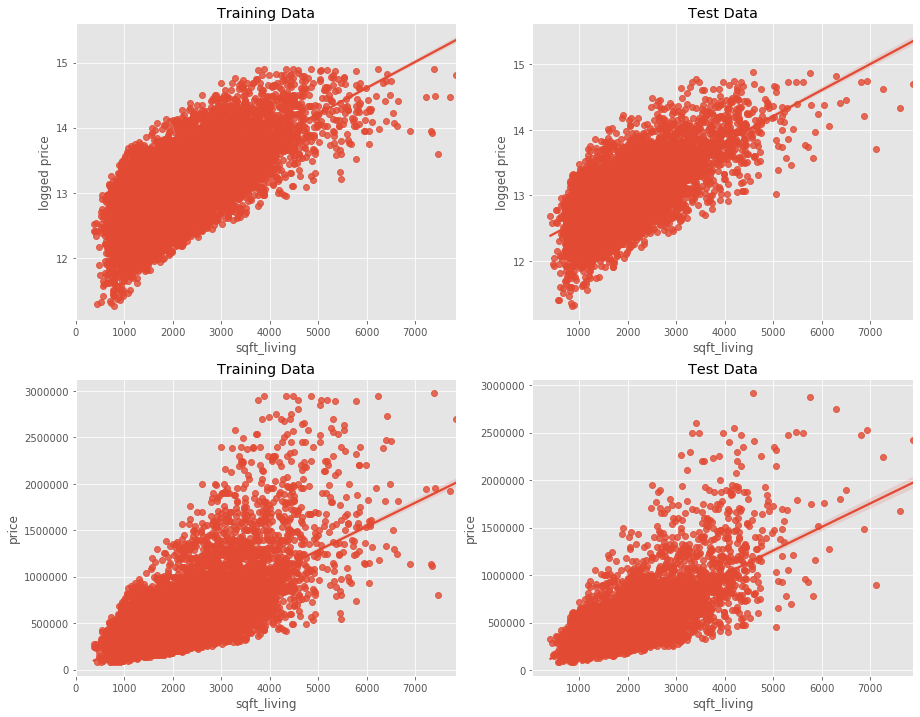

In [422]:
# plot coefficients that are closely correlated with price, for presentation to non-technical stakeholders

plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['sqft_living'], y_train_logged)
plt.title('Training Data')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['sqft_living'], y_test_logged)
plt.title('Test Data')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(X_train6['sqft_living'], y_train)
plt.title('Training Data')

ax4 = plt.subplot(224)
sns.regplot(X_test6['sqft_living'], y_test)
plt.title('Test Data');

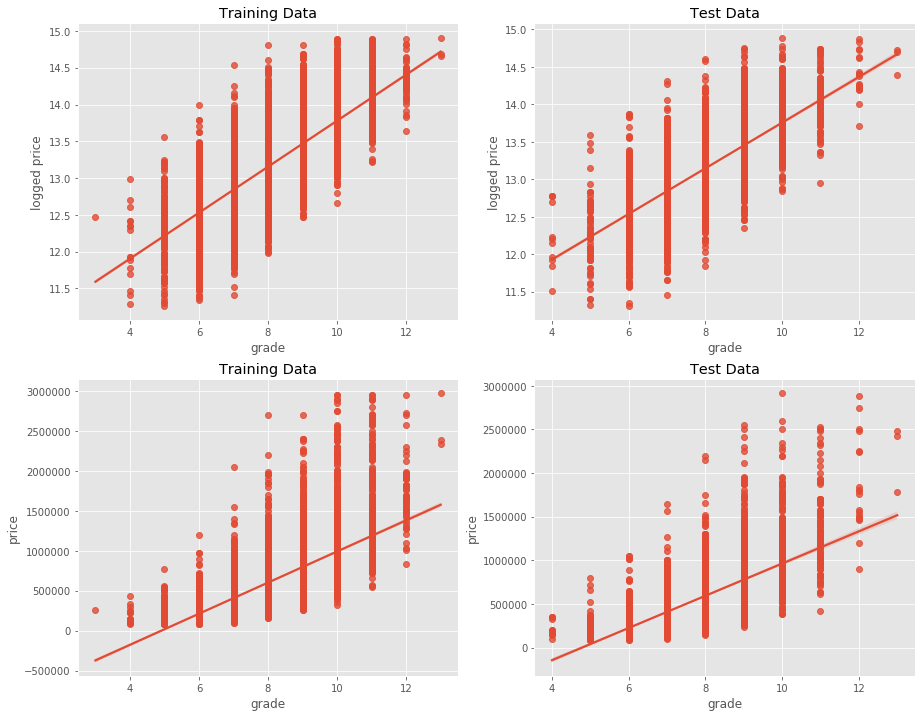

In [423]:
plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['grade'], y_train_logged)
plt.title('Training Data')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['grade'], y_test_logged)
plt.title('Test Data')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(X_train6['grade'], y_train)
plt.title('Training Data')

ax4 = plt.subplot(224)
sns.regplot(X_test6['grade'], y_test)
plt.title('Test Data');

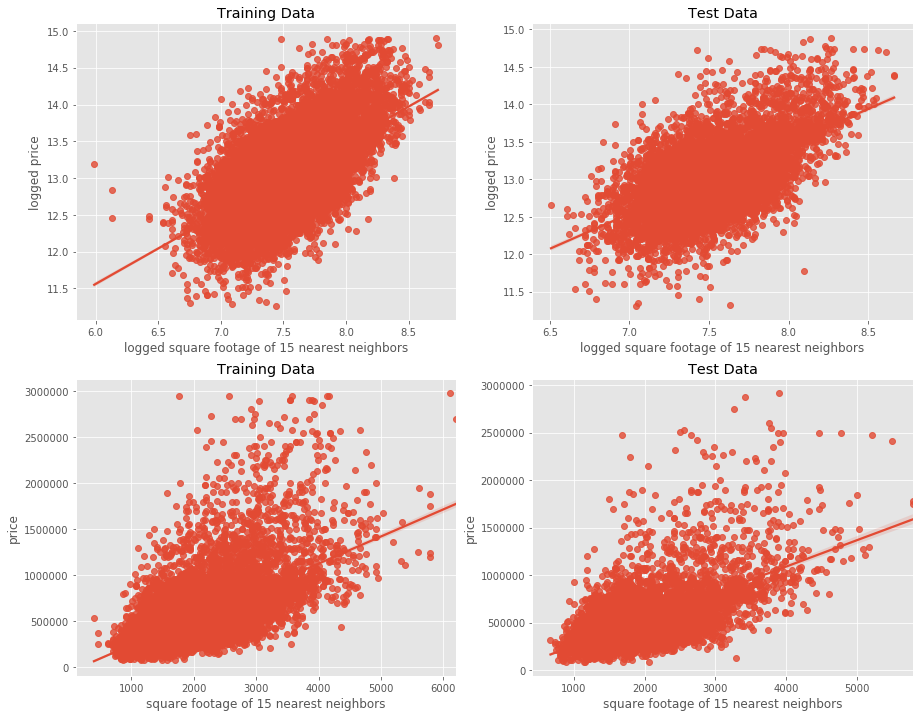

In [424]:
plt.subplots(figsize=(15,12));

ax1 = plt.subplot(221)
sns.regplot(X_train6['sqft_living15'], y_train_logged)
plt.title('Training Data')
plt.xlabel('logged square footage of 15 nearest neighbors')
plt.ylabel('logged price')

ax2 = plt.subplot(222)
sns.regplot(X_test6['sqft_living15'], y_test_logged)
plt.title('Test Data')
plt.xlabel('logged square footage of 15 nearest neighbors')
plt.ylabel('logged price')

ax3 = plt.subplot(223)
sns.regplot(np.expm1(X_train6['sqft_living15']), y_train)
plt.title('Training Data')
plt.xlabel('square footage of 15 nearest neighbors')

ax4 = plt.subplot(224)
sns.regplot(np.expm1(X_test6['sqft_living15']), y_test)
plt.title('Test Data')
plt.xlabel('square footage of 15 nearest neighbors');

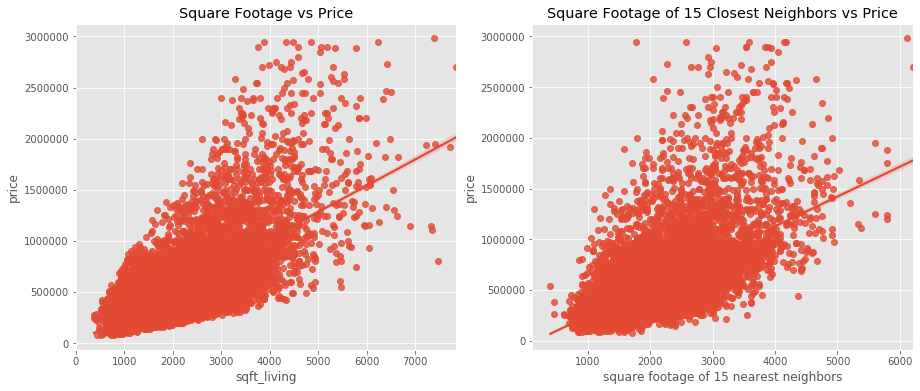

In [452]:
# save figures for presentation

plt.subplots(figsize=(15,6));

ax1 = plt.subplot(121)
sns.regplot(X_train6['sqft_living'], y_train)
plt.title('Square Footage vs Price')

ax3 = plt.subplot(122)
sns.regplot(np.expm1(X_train6['sqft_living15']), y_train)
plt.title('Square Footage of 15 Closest Neighbors vs Price')
plt.xlabel('square footage of 15 nearest neighbors')

plt.savefig('images/regplots')

### Model 7: Testing Removing Multicolinear Columns

In [425]:
# let's see if removing multicolinearity helps
# find top correlations
# code from Flatiron Data Science course's Multicollinearity Lab

df=X_train6.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [426]:
df[(df.cc>.75) & (df.cc <1)]

# high correlations among these four variables:
# sqft_living, sqft_above, grade, bathrooms

,cc
pairs,
"(sqft_above, sqft_living)",0.87374
"(sqft_living, grade)",0.75806
"(sqft_living, bathrooms)",0.75319
"(grade, sqft_above)",0.75205


In [427]:
best_r2

{'train': 0.831058, 'test': 0.825734}

In [428]:
# iterate thru combinations of highly correlated variables to see if dropping them increases r2

correlated = ['sqft_living',
              'sqft_above',
              'grade',
              'bathrooms']

combs_list=[]

for n in range(1,4):
    
    comb = combinations(correlated,n)
    combs_list = combs_list + list(comb)
    
combs_list

for c in combs_list: 
    print(c)
    X_train7 = X_train6.drop(columns = list(c))
    X_test7 = X_test6.drop(columns = list(c))
    y_train_pred7, y_test_pred7 = scale_lin_reg(X_train=X_train7, y_train=y_train_logged, X_test=X_test7)
    eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred7, y_test=y_test_logged, y_test_pred=y_test_pred7)
    print('\n')

# despite the multicolinearity, dropping combinations of these columns does not result in an improved R2
# dropping sqft_above returns almost exactly the same result

('sqft_living',)
Training Data 
 R-Squared: 0.830418 

Test Data 
 R-Squared: 0.825369


('sqft_above',)
Training Data 
 R-Squared: 0.831058 

Test Data 
 R-Squared: 0.82574


('grade',)
Training Data 
 R-Squared: 0.810266 

Test Data 
 R-Squared: 0.802736


('bathrooms',)
Training Data 
 R-Squared: 0.829158 

Test Data 
 R-Squared: 0.824471


('sqft_living', 'sqft_above')
Training Data 
 R-Squared: 0.816 

Test Data 
 R-Squared: 0.810406


('sqft_living', 'grade')
Training Data 
 R-Squared: 0.809057 

Test Data 
 R-Squared: 0.801954


('sqft_living', 'bathrooms')
Training Data 
 R-Squared: 0.828259 

Test Data 
 R-Squared: 0.823891


('sqft_above', 'grade')
Training Data 
 R-Squared: 0.810259 

Test Data 
 R-Squared: 0.802671


('sqft_above', 'bathrooms')
Training Data 
 R-Squared: 0.829154 

Test Data 
 R-Squared: 0.824497


('grade', 'bathrooms')
Training Data 
 R-Squared: 0.807461 

Test Data 
 R-Squared: 0.800854


('sqft_living', 'sqft_above', 'grade')
Training Data 
 R-Squared: 

### Model 8: Test removing features with high p-values

In [429]:
# according to the statsmodels output, p-values for sqft_above and sqft_basement were above 0.05

X_train8 = X_train6.copy()
X_train8.drop(columns=['sqft_above', 'sqft_basement'], inplace=True)

X_test8 = X_test6.copy()
X_test8.drop(columns=['sqft_above', 'sqft_basement'], inplace=True)


In [430]:
y_train_pred8, y_test_pred8 = scale_lin_reg(X_train=X_train8, y_train=y_train_logged, X_test=X_test8)


In [431]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred8, y_test=y_test_logged, y_test_pred=y_test_pred8)


Training Data 
 R-Squared: 0.831025 

Test Data 
 R-Squared: 0.825705


In [432]:
unlog_MAE_RMSE(y_train=y_train, y_train_logged_pred=y_train_pred8, y_test=y_test, y_test_logged_pred=y_test_pred8)


Training Data 
 Mean Absolute Error: 88274.84 
 Root Mean Squared Error: 151654.38 

Test Data 
 Mean Absolute Error: 86930.64 
 Root Mean Squared Error: 144778.39 



In [433]:
best_r2
# no improvement in r2 for Model 8, but let's keep this model since at least it reduces multicolinearity
# and removes coefficients with high p-values

{'train': 0.831058, 'test': 0.825734}

In [434]:
# look at coefficients for Model 8

model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train8, columns=X_train8.columns, index=X_train8.index)))
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     4355.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:04:10   Log-Likelihood:                 1908.8
No. Observations:               15072   AIC:                            -3782.
Df Residuals:                   15054   BIC:                            -3645.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.0226      0.172     98.829      0.000      16.685      17.360
bedrooms         -0.0149      0.003     -5.951      0.000      -0.020      -0.010
bathrooms         0.0558      0.004     13.404      0.000       0.048       0.064
sqft_living       0.0002   4.35e-06     40.889      0.000       0.000       0.000
sqft_lot       8.785e-07   7.06e-08     12.444      0.000     7.4e-07    1.02e-06
floors            0.0213      0.004      4.870      0.000       0.013       0.030
condition         0.0420      0.003     14.218      0.000       0.036       0.048
grade             0.1181      0.003     43.205      0.000       0.113       0.123
yr_built         -0.0028   8.58e-05    -33.197      0.000      -0.003      -0.003
sqft_living15     0.1598      0.009     18.106      0.000       0.142       0.177
sqft_lot15       -0.0364      0.003    -10.727      0.000      -0.043      -0.030
renovated         0.0749      0.010      7.393      0.000       0.055       0.095
Zip Class 2      -0.2832      0.038     -7.513      0.000      -0.357      -0.209
Zip Class 3      -0.4949      0.037    -13.348      0.000      -0.568      -0.422
Zip Class 4      -0.6148      0.037    -16.655      0.000      -0.687      -0.542
Zip Class 5      -0.8203      0.037    -22.140      0.000      -0.893      -0.748
Zip Class 6      -1.1032      0.037    -29.780      0.000      -1.176      -1.031
Zip Class 7      -1.2142      0.038    -31.560      0.000      -1.290      -1.139
==============================================================================
Omnibus:                      835.184   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3079.639
Skew:                           0.157   Prob(JB):                         0.00
Kurtosis:                       5.192   Cond. No.                     3.62e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 9: Experiment with categorizing year built

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price
753,2,2.50000,2380,6600,1.00000,3,8,2010,7.53369,8.79482,0,0,0,1,0,0,0,699800.00000
1418,4,3.75000,3190,17186,2.00000,3,10,1999,7.73631,9.51015,0,0,0,0,0,1,0,1700000.00000
8178,3,2.50000,1730,6930,2.00000,3,8,1994,7.48437,8.84362,0,0,0,0,0,1,0,258000.00000
2254,4,2.00000,1870,8750,1.00000,3,7,1977,7.47873,9.01274,0,0,0,0,0,1,0,245000.00000
4063,8,3.00000,2850,12714,1.00000,3,7,1959,7.29980,8.50553,0,0,0,0,0,1,0,373000.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50000,2230,5800,2.00000,3,7,2004,7.70976,8.71407,0,0,0,1,0,0,0,440000.00000
21575,4,2.75000,2770,3852,2.00000,3,8,2014,7.50108,8.63782,0,0,0,0,0,1,0,572000.00000
5390,4,1.50000,1530,9000,1.00000,4,6,1976,7.32647,9.04782,0,0,0,0,1,0,0,299800.00000
860,1,0.75000,380,15000,1.00000,3,5,1963,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000


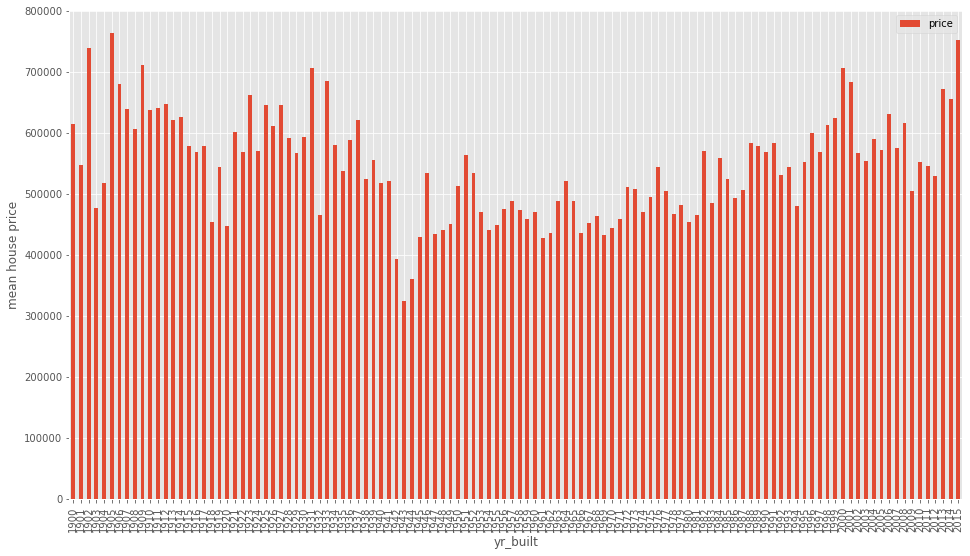

In [435]:
# made a df to add price back to X variables table, so we can make a pivot table
built_df = pd.concat([X_train8, y_train], axis=1)
built_pivot = built_df.pivot_table(values='price', index='yr_built', ).sort_values(by='yr_built')

# plot a bar graph to look at possible categories
built_pivot.plot(kind='bar', figsize=(16,9))
plt.ylabel('mean house price')
plt.legend;

built_df

# hmmm, almost looks like older homes and new homes are highly valued, while homes in the middle are not

In [436]:
# create a dictionary of years, showing the corresponding categories

years_list = list(built_pivot.index)
years_dict = {}

for i in years_list[0:41]:
    years_dict[i] = 'pre-war'
    
for i in years_list[41:88]:
    years_dict[i] = 'mid-century'

for i in years_list[88:117]:
    years_dict[i] = 'recent'
    
years_dict

{1900: 'pre-war',
 1901: 'pre-war',
 1902: 'pre-war',
 1903: 'pre-war',
 1904: 'pre-war',
 1905: 'pre-war',
 1906: 'pre-war',
 1907: 'pre-war',
 1908: 'pre-war',
 1909: 'pre-war',
 1910: 'pre-war',
 1911: 'pre-war',
 1912: 'pre-war',
 1913: 'pre-war',
 1914: 'pre-war',
 1915: 'pre-war',
 1916: 'pre-war',
 1917: 'pre-war',
 1918: 'pre-war',
 1919: 'pre-war',
 1920: 'pre-war',
 1921: 'pre-war',
 1922: 'pre-war',
 1923: 'pre-war',
 1924: 'pre-war',
 1925: 'pre-war',
 1926: 'pre-war',
 1927: 'pre-war',
 1928: 'pre-war',
 1929: 'pre-war',
 1930: 'pre-war',
 1931: 'pre-war',
 1932: 'pre-war',
 1933: 'pre-war',
 1934: 'pre-war',
 1935: 'pre-war',
 1936: 'pre-war',
 1937: 'pre-war',
 1938: 'pre-war',
 1939: 'pre-war',
 1940: 'pre-war',
 1941: 'mid-century',
 1942: 'mid-century',
 1943: 'mid-century',
 1944: 'mid-century',
 1945: 'mid-century',
 1946: 'mid-century',
 1947: 'mid-century',
 1948: 'mid-century',
 1949: 'mid-century',
 1950: 'mid-century',
 1951: 'mid-century',
 1952: 'mid-century'

In [437]:
# add a column with yr_built categories

built_df['built_cat'] = built_df['yr_built'].map(lambda x: years_dict[x])
built_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price,built_cat
753,2,2.50000,2380,6600,1.00000,3,8,2010,7.53369,8.79482,0,0,0,1,0,0,0,699800.00000,recent
1418,4,3.75000,3190,17186,2.00000,3,10,1999,7.73631,9.51015,0,0,0,0,0,1,0,1700000.00000,recent
8178,3,2.50000,1730,6930,2.00000,3,8,1994,7.48437,8.84362,0,0,0,0,0,1,0,258000.00000,recent
2254,4,2.00000,1870,8750,1.00000,3,7,1977,7.47873,9.01274,0,0,0,0,0,1,0,245000.00000,mid-century
4063,8,3.00000,2850,12714,1.00000,3,7,1959,7.29980,8.50553,0,0,0,0,0,1,0,373000.00000,mid-century
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50000,2230,5800,2.00000,3,7,2004,7.70976,8.71407,0,0,0,1,0,0,0,440000.00000,recent
21575,4,2.75000,2770,3852,2.00000,3,8,2014,7.50108,8.63782,0,0,0,0,0,1,0,572000.00000,recent
5390,4,1.50000,1530,9000,1.00000,4,6,1976,7.32647,9.04782,0,0,0,0,1,0,0,299800.00000,mid-century
860,1,0.75000,380,15000,1.00000,3,5,1963,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000,mid-century


In [438]:
# one hot encode classification column

built_cat_columns = pd.get_dummies(built_df['built_cat'], drop_first=True)
built_cat_columns

built_df = pd.concat([built_df, built_cat_columns], axis=1)
built_df.drop(columns=['yr_built','built_cat'], inplace=True)

In [439]:
built_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,price,pre-war,recent
753,2,2.50000,2380,6600,1.00000,3,8,7.53369,8.79482,0,0,0,1,0,0,0,699800.00000,0,1
1418,4,3.75000,3190,17186,2.00000,3,10,7.73631,9.51015,0,0,0,0,0,1,0,1700000.00000,0,1
8178,3,2.50000,1730,6930,2.00000,3,8,7.48437,8.84362,0,0,0,0,0,1,0,258000.00000,0,1
2254,4,2.00000,1870,8750,1.00000,3,7,7.47873,9.01274,0,0,0,0,0,1,0,245000.00000,0,0
4063,8,3.00000,2850,12714,1.00000,3,7,7.29980,8.50553,0,0,0,0,0,1,0,373000.00000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,3,2.50000,2230,5800,2.00000,3,7,7.70976,8.71407,0,0,0,1,0,0,0,440000.00000,0,1
21575,4,2.75000,2770,3852,2.00000,3,8,7.50108,8.63782,0,0,0,0,0,1,0,572000.00000,0,1
5390,4,1.50000,1530,9000,1.00000,4,6,7.32647,9.04782,0,0,0,0,1,0,0,299800.00000,0,0
860,1,0.75000,380,15000,1.00000,3,5,7.06476,9.61581,0,0,0,0,0,0,1,245000.00000,0,0


In [440]:
# now we just have to stick these columns back onto the training and test sets

#training set first
X_train9 = X_train8.copy()

columns_to_add = built_df[['pre-war', 'recent']]
X_train9 = pd.concat([X_train9, columns_to_add], axis=1)
X_train9.drop(columns='yr_built', inplace=True)

In [441]:
# now do test set

X_test9 = X_test8.copy()

X_test9['built_cat'] = X_test9['yr_built'].map(lambda x: years_dict[x])
built_cat_columns = pd.get_dummies(X_test9['built_cat'], drop_first=True)

X_test9 = pd.concat([X_test9, built_cat_columns], axis=1)
X_test9.drop(columns=['yr_built','built_cat'], inplace=True)

X_test9

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_living15,sqft_lot15,renovated,Zip Class 2,Zip Class 3,Zip Class 4,Zip Class 5,Zip Class 6,Zip Class 7,pre-war,recent
3686,3,0.75000,850,8573,1.00000,3,6,6.74524,9.03384,0,0,0,0,0,1,0,0,0
10247,3,1.00000,1510,6083,1.00000,4,6,7.31986,8.65032,0,0,0,1,0,0,0,1,0
4037,4,2.25000,1790,42000,1.00000,3,7,7.63046,10.82166,0,0,0,0,1,0,0,0,0
3437,2,1.50000,1140,2500,1.00000,3,7,7.31322,8.51719,0,0,0,0,0,1,0,0,1
19291,3,1.00000,1500,3920,1.00000,3,7,7.40245,8.29829,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9400,4,3.50000,2650,3060,2.00000,3,9,7.29302,8.02617,0,0,0,1,0,0,0,0,1
9092,4,2.75000,2670,6780,2.00000,5,8,7.78322,8.69768,0,0,0,0,1,0,0,1,0
6650,3,1.75000,1600,10280,1.00000,3,7,7.37149,8.99962,0,0,0,1,0,0,0,0,0
21095,5,3.50000,2760,3865,2.50000,3,8,7.85941,8.43098,0,0,0,0,1,0,0,0,1


In [442]:
# let's test model 9!

y_train_pred9, y_test_pred9 = scale_lin_reg(X_train=X_train9, y_train=y_train_logged, X_test=X_test9)

In [443]:
eval_r2(y_train=y_train_logged, y_train_pred=y_train_pred9, y_test=y_test_logged, y_test_pred=y_test_pred9)

# R-squared is less than for Model 8
# so, segmenting year_built into categories does not help explain any variance
# perhaps this variance can be explained by square footage and location alone

Training Data 
 R-Squared: 0.828802 

Test Data 
 R-Squared: 0.824774


In [444]:
best_r2

{'train': 0.831058, 'test': 0.825734}

In [445]:
model = sm.OLS(y_train_logged, sm.add_constant(pd.DataFrame(X_train9, columns=X_train9.columns, index=X_train9.index)))
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     4049.
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:04:11   Log-Likelihood:                 1810.3
No. Observations:               15072   AIC:                            -3583.
Df Residuals:                   15053   BIC:                            -3438.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5503      0.073    158.954      0.000      11.408      11.693
bedrooms         -0.0107      0.003     -4.212      0.000      -0.016      -0.006
bathrooms         0.0372      0.004      9.033      0.000       0.029       0.045
sqft_living       0.0002   4.35e-06     42.537      0.000       0.000       0.000
sqft_lot       7.875e-07   7.17e-08     10.989      0.000    6.47e-07    9.28e-07
floors           -0.0058      0.005     -1.221      0.222      -0.015       0.004
condition         0.0522      0.003     17.462      0.000       0.046       0.058
grade             0.1126      0.003     41.192      0.000       0.107       0.118
sqft_living15     0.1418      0.009     15.915      0.000       0.124       0.159
sqft_lot15       -0.0290      0.004     -8.250      0.000      -0.036      -0.022
renovated         0.1067      0.010     10.562      0.000       0.087       0.126
Zip Class 2      -0.2881      0.038     -7.592      0.000      -0.362      -0.214
Zip Class 3      -0.5113      0.037    -13.699      0.000      -0.584      -0.438
Zip Class 4      -0.6387      0.037    -17.191      0.000      -0.712      -0.566
Zip Class 5      -0.8433      0.037    -22.612      0.000      -0.916      -0.770
Zip Class 6      -1.1356      0.037    -30.461      0.000      -1.209      -1.063
Zip Class 7      -1.2398      0.039    -32.016      0.000      -1.316      -1.164
pre-war           0.1529      0.006     27.387      0.000       0.142       0.164
recent           -0.0343      0.006     -5.900      0.000      -0.046      -0.023
==============================================================================
Omnibus:                      902.979   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3205.348
Skew:                           0.221   Prob(JB):                         0.00
Kurtosis:                       5.215   Cond. No.                     2.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Conclusions and Future Work

To accurately price homes in King County, the real estate firm should use a model that segments zip codes into price-based categories, such as Model 8.  This model combines data about house features that are highly correlated with price, such as square footage, with knowledge of the mean house price of each zip code, to produce predictions that explain 83% of the variance from the mean price.  Model 8 is a significant improvement over the baseline regression model, which only explains 63% of the variance.  In addition, while the baseline regression model's predictions were an average of \\$136K off from the actual prices of the test data, Model 8's Mean Absolute Error was only $87K for the test data. \
\
Square footage and grade have the strongest positive correlation with price, but the model vastly improved after zip code classifications were included.  Unsurprisingly, location seems extremely important to home buyers in the Seattle area, which is a diverse landscape that includes, urban, suburban, and rural neighborhoods. \
\
Much work remains to investigate potential improvements to this model.  In particular, including interactions among X variables may increase the model's accuracy.  Since square footage and zip code are such powerful predictors of price, perhaps an interaction between these variables would enhance the model.  Also, since zip code classification was so effective in improving the model, perhaps including a few more zip classes would help by segmenting the market even further.  

In addition, the month when the house was sold may affect price, and was not tested in these models.  Also not tested was a feature that would indicate whether the house was recently renovated, for example in the past 20 years.  It may also help to programmatically iterate through the X-variables to select the best features for inclusion in the model.

Finally, a handful of properties (less than half of one per cent) must be excluded from this model.  Creating models that can generate predictions for these homes as well would benefit the real estate firm.